<center><h1>Hu_Yaqi_HW5</h1></center>
<br>
<br>

Name: Hu, Yaqi
<br>
Github Username: YaqiHu23
<br>
USC ID: 7191264555

## 1. Decision Trees as Interpretable Models

Import packages

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import heapq
import xgboost as xgb
import chardet
import graphviz 
import statsmodels.api as sm
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, _tree
from skmultilearn.problem_transform import LabelPowerset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve,roc_auc_score, RocCurveDisplay, mean_squared_error

### (a) Obtain Data

Get the Accute Inamations Data Set

In [27]:
# Read .names file
# .names file contains the dataset information, it helps me to understand the dataset

with open('../data/diagnosis.names', 'r') as f:
    lines = f.readlines()

# for line in lines:
#     print(line)

##### Fixed:
 1. The data not in UTF-8, so here I use chardet package to find the file type----UTF-16
 2. Column Temperature of patient, like 35,5 is not a float, we need to transfer it to 35.5.
 3. NO and Yes is not numeric, I change no to 0, yes to 1

In [28]:
# Read .data file
# Column_names get from the .names file
column_names = ['Temperature of patient', 'Occurrence of nausea', 'Lumbar pain', 'Urine pushing', 'Micturition pains', 'Burning...', 'Inflammation of urinary bladder', 'Nephritis of renal pelvis origin']

def find_encoding(fname):
    r_file = open(fname, 'rb').read()
    result = chardet.detect(r_file)
    charenc = result['encoding']
    return charenc

encoding_type = find_encoding('../data/diagnosis.data')
print(f'Here is the encoding_type: {encoding_type}')

with open('../data/diagnosis.data', 'r', encoding=encoding_type) as f:
    datalines = f.readlines()

decision_data = []
for line in datalines:
    line = line.strip()
    column = line.split('\t')
    # print(column)
    decision_data.append(column)

print(f'Here is the Dataset data information:')
decision_data = pd.DataFrame(decision_data)
decision_data.columns = column_names

# transfer , to .
decision_data['Temperature of patient'] = decision_data['Temperature of patient'].replace(',', '.', regex=True)
# transfer no, yes to 0, 1
for name in column_names[1:]:
    decision_data[name] = decision_data[name].replace('no', 0)
    decision_data[name] = decision_data[name].replace('yes', 1)
decision_data


Here is the encoding_type: UTF-16
Here is the Dataset data information:


,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing,Micturition pains,Burning...,Inflammation of urinary bladder,Nephritis of renal pelvis origin
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


### (b) Build a decision tree

##### Here I use the powerset method to convert it to a multiclass dataset
After transform, we have four classes: None, Inflammation, Nephritis, both of them.

In [29]:
# Let we separate the X and y

X = decision_data.iloc[:, :-2]
y = decision_data.iloc[:, -2:]

lp = LabelPowerset()
y = lp.transform(y)

clf = DecisionTreeClassifier(random_state=1729)
clf.fit(X, y)

DecisionTreeClassifier(random_state=1729)

##### Print the DecisionTree

Two ways to do that:

[Text(0.4, 0.9, 'x[2] <= 0.5\ngini = 0.735\nsamples = 120\nvalue = [30, 40, 31, 19]'),
 Text(0.2, 0.7, 'x[3] <= 0.5\ngini = 0.32\nsamples = 50\nvalue = [10, 40, 0, 0]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [10, 0, 0, 0]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [0, 40, 0, 0]'),
 Text(0.6, 0.7, 'x[0] <= 37.95\ngini = 0.649\nsamples = 70\nvalue = [20, 0, 31, 19]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [20, 0, 0, 0]'),
 Text(0.7, 0.5, 'x[1] <= 0.5\ngini = 0.471\nsamples = 50\nvalue = [0, 0, 31, 19]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [0, 0, 21, 0]'),
 Text(0.8, 0.3, 'x[3] <= 0.5\ngini = 0.452\nsamples = 29\nvalue = [0, 0, 10, 19]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [0, 0, 10, 0]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [0, 0, 0, 19]')]

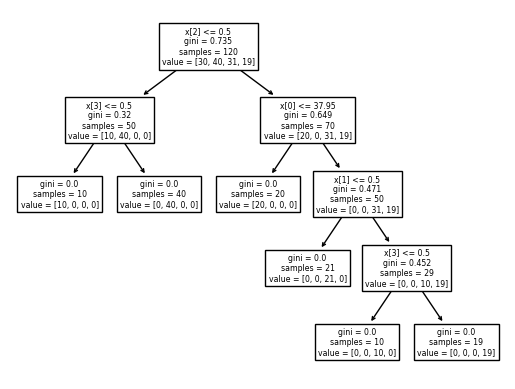

In [30]:
tree.plot_tree(clf)

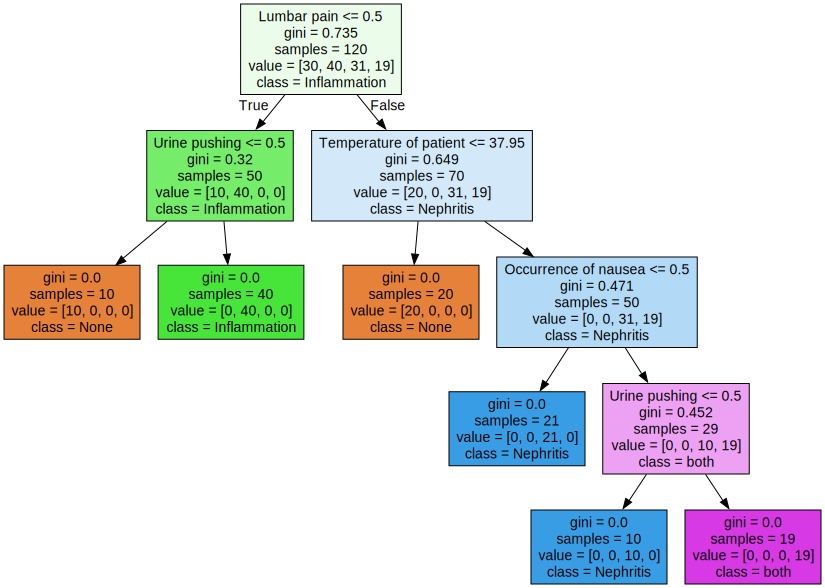

In [31]:
X_name = column_names[:-2]
y_name = ['None', 'Inflammation', 'Nephritis', 'both']
# print(X_name, y_name)

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X_name, class_names=y_name, filled=True)
graph = graphviz.Source(dot_data)  
graph

### (c) Convert the decision rules

code from https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html

In [32]:
def tree_to_code(tree, feature_names):
	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)

In [33]:
tree_to_code(clf, list(X_name))

def tree(Temperature of patient, Occurrence of nausea, Lumbar pain, Urine pushing, Micturition pains, Burning...):
  if Lumbar pain <= 0.5:
    if Urine pushing <= 0.5:
      return [[10.  0.  0.  0.]]
    else:  # if Urine pushing > 0.5
      return [[ 0. 40.  0.  0.]]
  else:  # if Lumbar pain > 0.5
    if Temperature of patient <= 37.95000076293945:
      return [[20.  0.  0.  0.]]
    else:  # if Temperature of patient > 37.95000076293945
      if Occurrence of nausea <= 0.5:
        return [[ 0.  0. 21.  0.]]
      else:  # if Occurrence of nausea > 0.5
        if Urine pushing <= 0.5:
          return [[ 0.  0. 10.  0.]]
        else:  # if Urine pushing > 0.5
          return [[ 0.  0.  0. 19.]]


### (d) Cost-complexity pruning

In [34]:
parameters = {'ccp_alpha':np.linspace(0, 0.01, 20)}

cv_clf = DecisionTreeClassifier(random_state=1729)

grid_search = GridSearchCV(cv_clf, parameters, cv=5)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_

print('Best ccp_alpha:', grid_search.best_params_)

Best ccp_alpha: {'ccp_alpha': 0.0}


[Text(0.4, 0.9, 'x[2] <= 0.5\ngini = 0.735\nsamples = 120\nvalue = [30, 40, 31, 19]'),
 Text(0.2, 0.7, 'x[3] <= 0.5\ngini = 0.32\nsamples = 50\nvalue = [10, 40, 0, 0]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [10, 0, 0, 0]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [0, 40, 0, 0]'),
 Text(0.6, 0.7, 'x[0] <= 37.95\ngini = 0.649\nsamples = 70\nvalue = [20, 0, 31, 19]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [20, 0, 0, 0]'),
 Text(0.7, 0.5, 'x[1] <= 0.5\ngini = 0.471\nsamples = 50\nvalue = [0, 0, 31, 19]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [0, 0, 21, 0]'),
 Text(0.8, 0.3, 'x[3] <= 0.5\ngini = 0.452\nsamples = 29\nvalue = [0, 0, 10, 19]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [0, 0, 10, 0]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [0, 0, 0, 19]')]

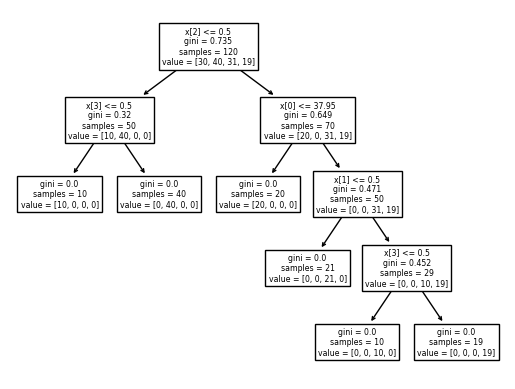

In [35]:
tree.plot_tree(best_model)

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [36]:
# .names file
with open('../data/communities.names', 'r') as f:
    lines = f.readlines()

# for line in lines:
#    print(line)

Number of attributes: 128

5 non-predictive (delete): state, county, community, communityname, fold (First 5 columns)

Goal:ViolentCrimesPerPop (Last Column)

Note here I delete 5 non-predictive features, as they are useless to predict.

In [37]:
# .data file
encoding_type = find_encoding('../data/communities.data')
print(f'Here is the encoding_type: {encoding_type}')

with open('../data/communities.data', 'r', encoding=encoding_type) as f:
    text = f.readlines()

# print(text)
# Split the data into rows
community_data = []
for line in text:
    line = line.strip()
    # print(line)
    column = line.split(',')
    # print(column)
    community_data.append(column)

# Transfer data to dataframe
community_data = pd.DataFrame(community_data)
# Remove first 5 unpredictive features
community_data = community_data.iloc[:, 5:]
community_data

Here is the encoding_type: ascii


,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.9,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.2,0.06,0.04,0.9,0.5,0.32,0.14,0.2
1,0,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,?,?,?,?,0,?,0.67
2,0,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,?,?,?,?,0,?,0.43
3,0.04,0.77,1,0.08,0.12,0.1,0.51,0.5,0.34,0.21,...,0.02,0.39,0.28,?,?,?,?,0,?,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,?,?,?,?,0,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.4,0.1,0.87,0.12,0.16,0.43,0.51,0.35,0.3,...,0.01,0.28,0.05,?,?,?,?,0,?,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.2,?,?,?,?,0,?,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.5,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.1,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


### (b) Missing values

Here I use SimpleImputer with Mean to replace missing values.\
Note: I will split the dataset into train/test after replace the missing value.\
Note: different method will give different mse error later.

In [38]:
# '?' cannot be handled by simpleimputer, we need to replace it with np.nan
community_data.replace('?', np.nan, inplace=True)

imputer = SimpleImputer(strategy='mean')
community_data = pd.DataFrame(imputer.fit_transform(community_data), columns = community_data.columns)

community_data

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


In [39]:
# Now the dataset is fixed from missing values
# Split it to train and test (train, test)--(1495, 499) ---- [0-1494, 1495-1993]

train_X = community_data.iloc[:1495, :-1]
train_y = community_data.iloc[:1495, -1]

test_X = community_data.iloc[1495:, :-1]
test_y = community_data.iloc[1495:, -1]

### (c) Plot a correlation matrix

Note: Here I only use the training dataset to calculate value, mentioned by TA in piazza.\
and use mask to reduce the calculation, as they are symmetric\
Dark color - higher correlation

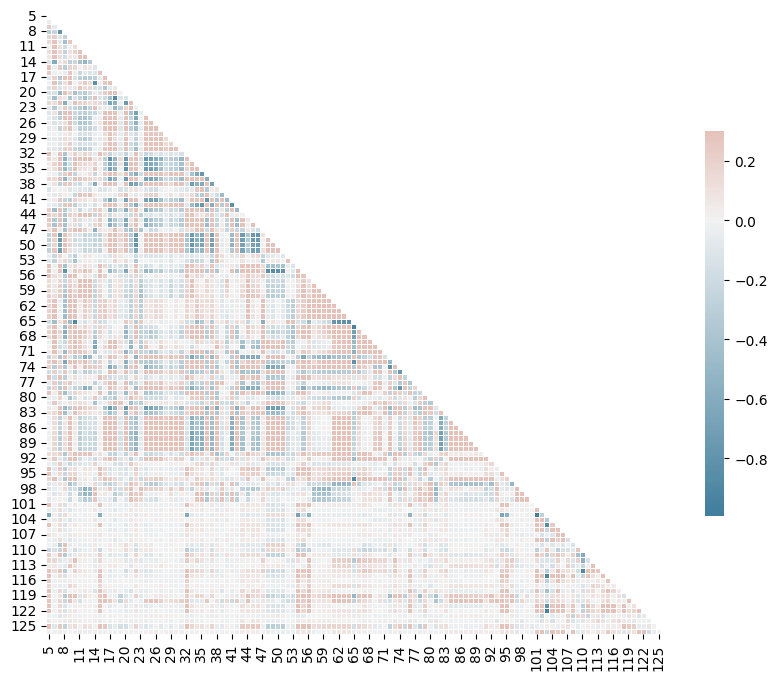

In [40]:
# Calculate correlation matrix
correlation = train_X.corr()

# I use a mask to reduce calculate twice
mask = np.triu(np.ones_like(correlation))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### (d) Calculate the Coefficient of Variation CV

Note: Here I use only the training data

In [41]:
# calculate cv for each feature (column in community_data)

cov = []

for col in train_X.columns:
    column = train_X[col]
    cov.append(column.std()/column.mean())
    
print(f'Here is the coefficient of variation numbers we get:', len(cov))
print(cov)

Here is the coefficient of variation numbers we get: 122
[2.2411046245803816, 0.3557995664028941, 1.4288854186502788, 0.3302126634442853, 1.3590996841590086, 1.6120910052284099, 0.3690831192095126, 0.29131481063520565, 0.5003099115377211, 0.4127759758512284, 2.0384614919156445, 0.6433181716461038, 0.5919781653450645, 0.3286140569015946, 0.7018978730820069, 0.36533458274419056, 0.36071544651696685, 0.7062058943769406, 0.34542095676300166, 0.5406701530549349, 0.5580794526579652, 0.519828467024788, 0.5993405451897995, 0.8183681264327709, 0.6148655265869312, 0.6732169975302172, 0.4840679504501612, 2.3424431162181776, 0.7544699780853562, 0.6804903296377433, 0.5337533808931809, 0.5926798349812525, 0.5624246988515312, 0.3514504046780546, 0.5135297542547976, 0.4028488486731367, 0.516379358776929, 0.4326695359842541, 0.3993660859242949, 0.4040615222426481, 0.36038982775895434, 0.3739045016849798, 0.3173754047085708, 0.33319465543955495, 0.3348755691618744, 0.3338334680337063, 0.3278008334193761

### (e) Scatter plots and box plots for highest CV features

In [42]:
pick_num = int(math.sqrt(128))
# print(pick_num)

index_list = list(enumerate(cov))
# print(index_list)
# find first pick_num greatest numbers/values
greatest_picknum = heapq.nlargest(pick_num, index_list, key=lambda x:x[1])

# Here our index is first start from 5, as first 5 is deleted.
index_selected = [index+5 for index, value in greatest_picknum]

index_selected = sorted(index_selected)
print(f'Here is the selected feature:', index_selected)

Here is the selected feature: [5, 10, 15, 32, 54, 56, 76, 94, 95, 118, 125]


Here I add label: column 127 to show which one could be significant

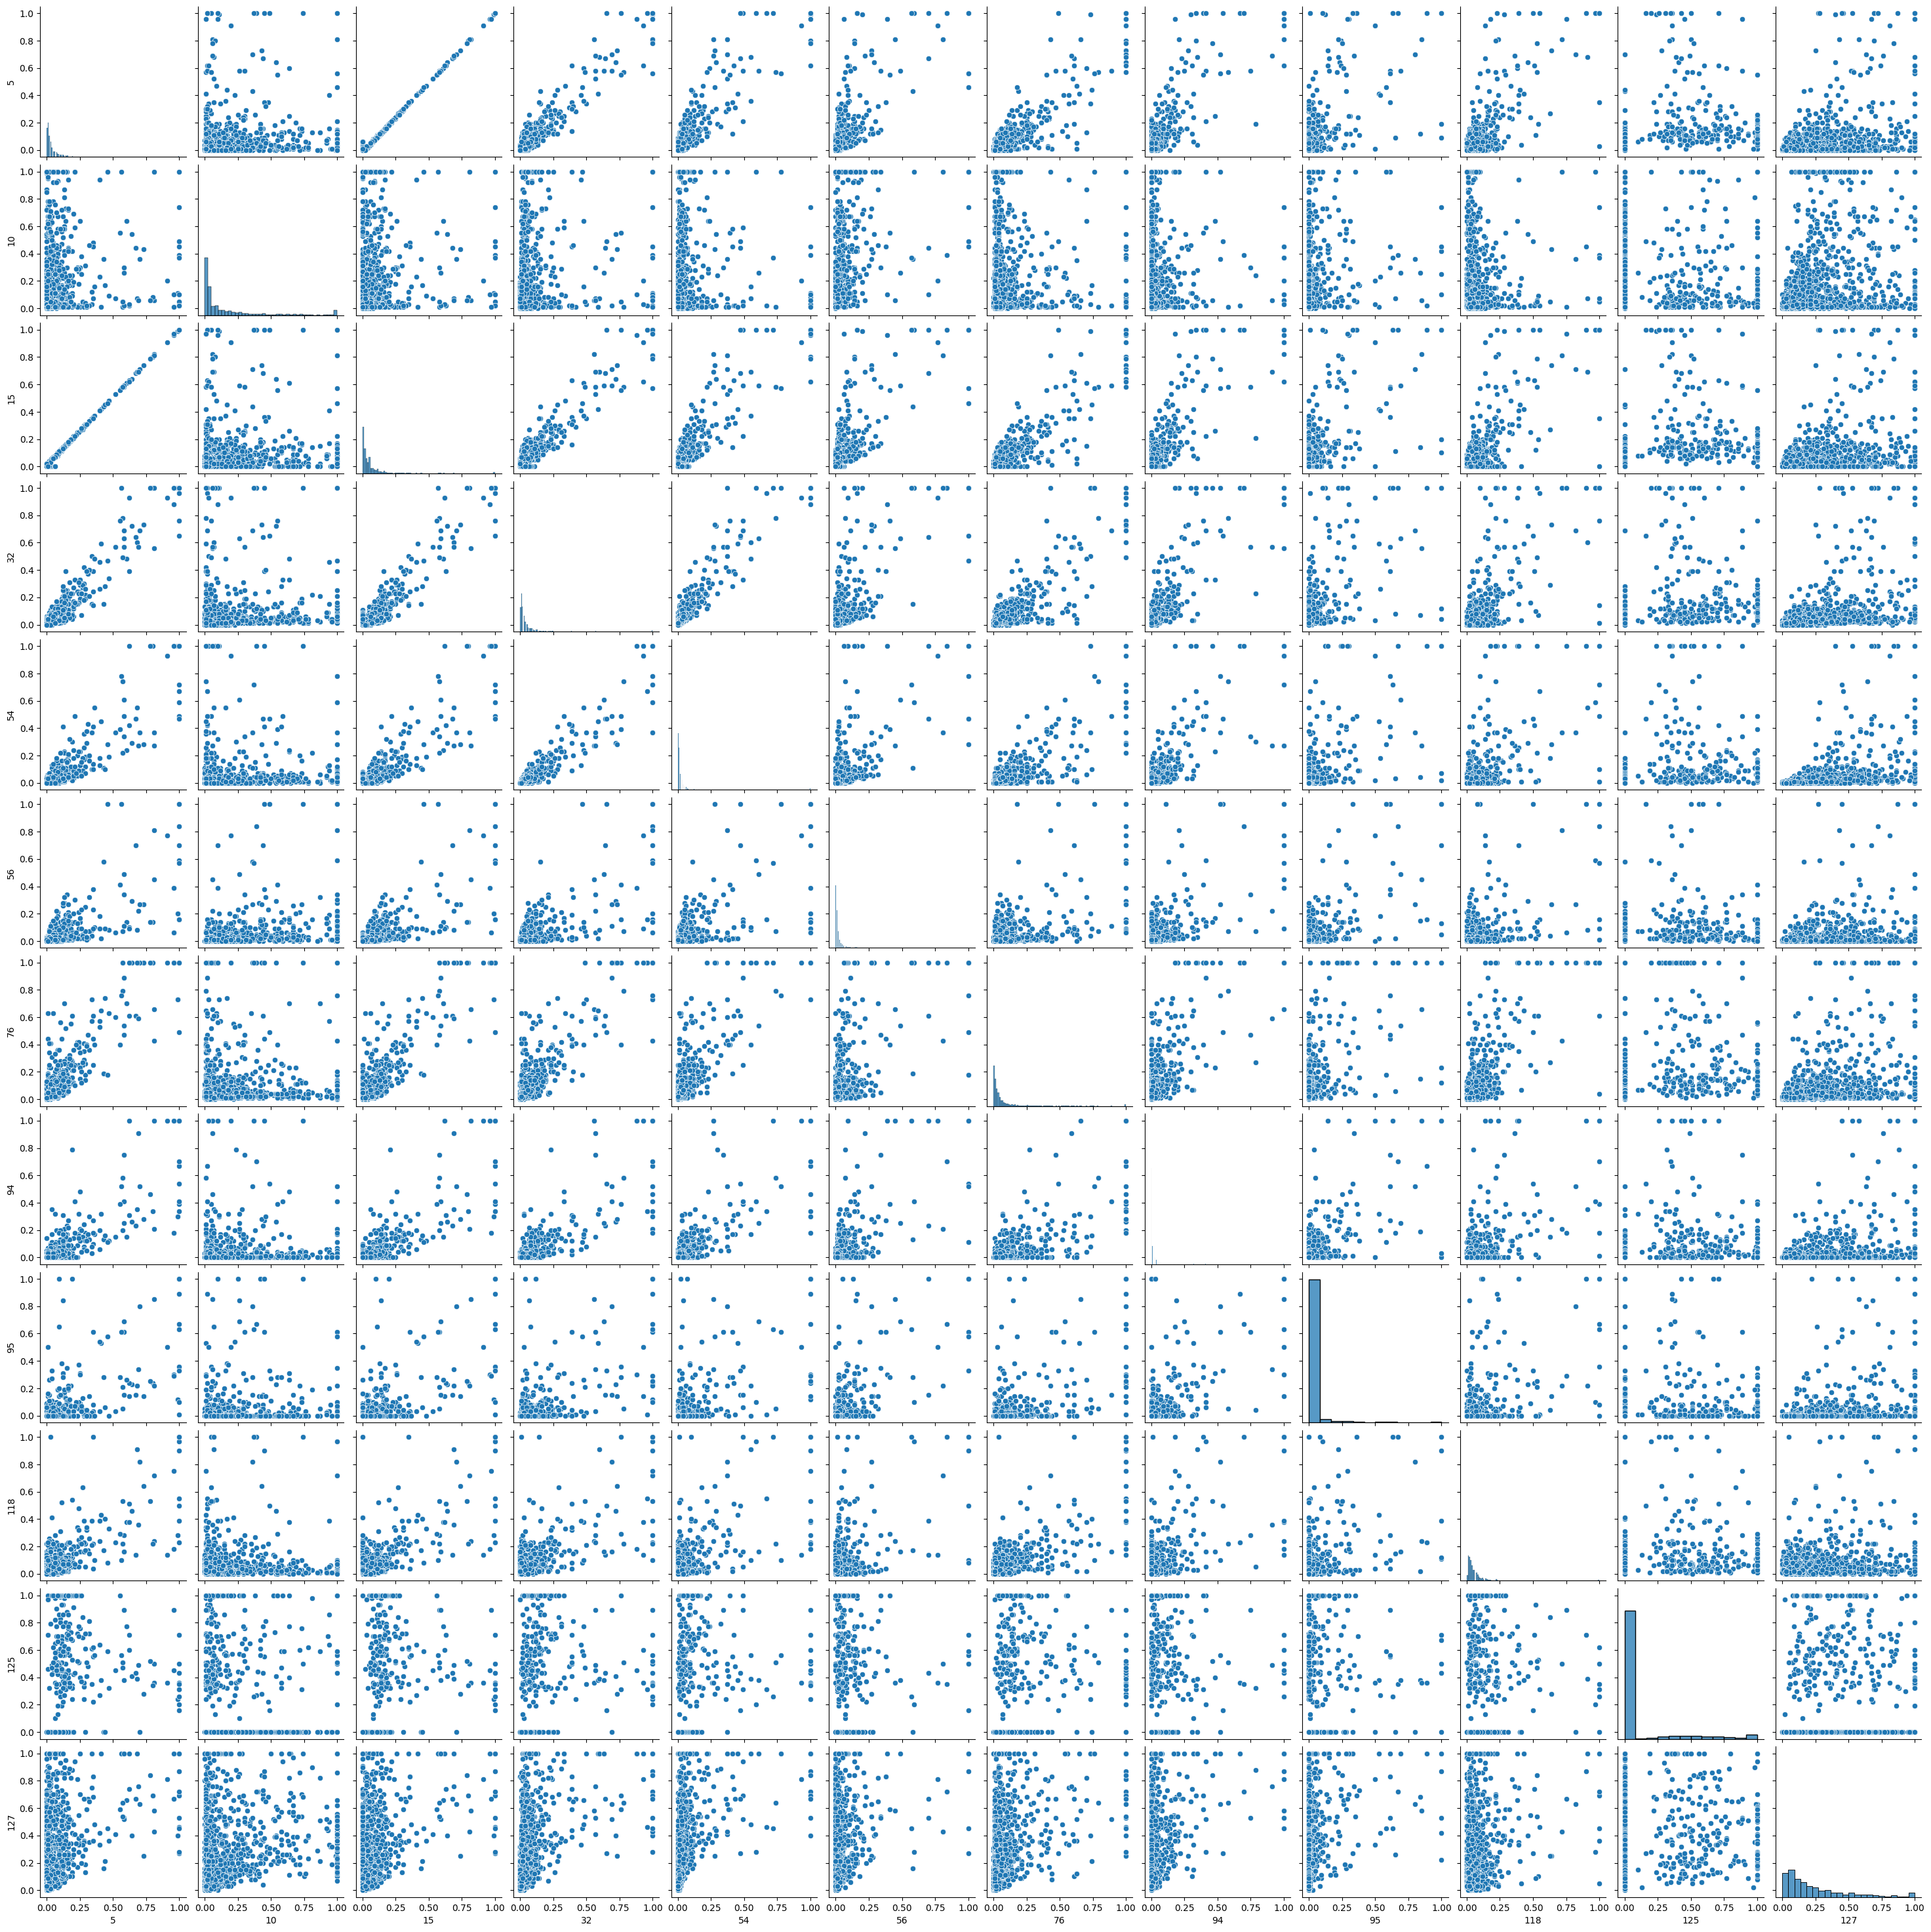

In [43]:
# Here add label in
selected_features = pd.concat([train_X[index_selected], train_y], axis=1)
sns.pairplot(selected_features)
plt.show()

From the scatter plot of these 11 features: \
There is no linear relationship with target 127 seen from the scatter plot.\
It looks like feature 125 has distinct clusters of datapoints (with many outliers). So maybe it is significant.\
I cannot get others are significant or not from the scatter plot


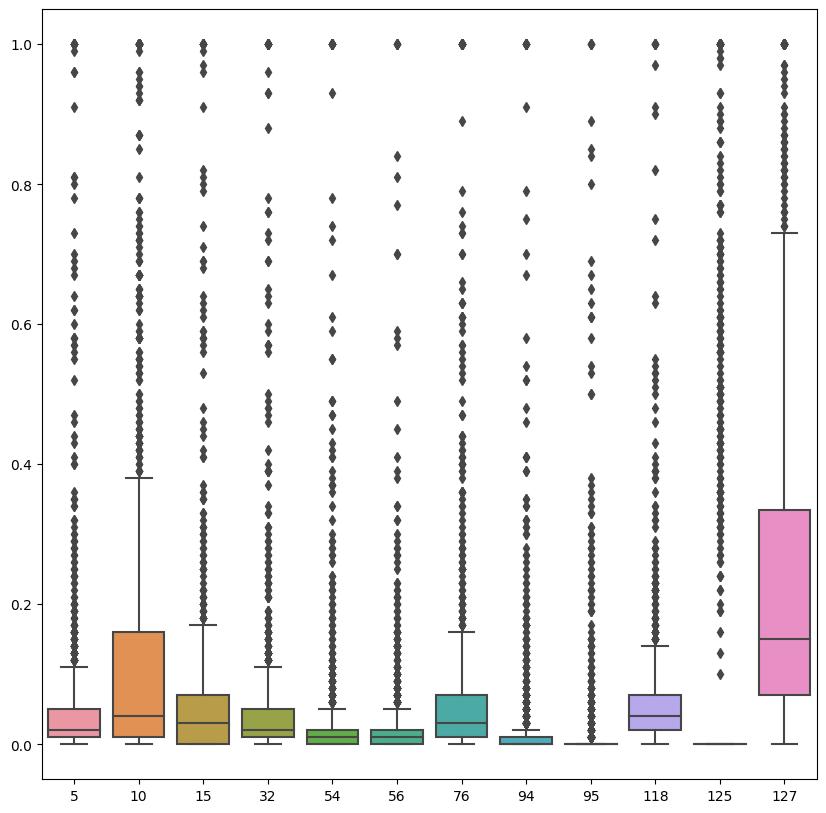

In [44]:
# Here 127 is label
plt.figure(figsize=(10,10))
sns.boxplot(data=selected_features)
plt.show()

### (f) Fit a linear model

In [45]:
linear_model = LinearRegression()
linear_model.fit(train_X, train_y)

linear_pred = linear_model.predict(test_X)

linear_mse = mean_squared_error(test_y, linear_pred)

print(f'Here is the linear model error with MSE: {linear_mse}')

Here is the linear model error with MSE: 0.7897255274265361


### (g) Fit a ridge regression model

In [46]:
alphas = [1e-3, 1e-2, 1e-1, 1, 10, 100]
ridge_model = RidgeCV(alphas=alphas, cv=5)
ridge_model.fit(train_X, train_y)

ridge_pred = ridge_model.predict(test_X)

ridge_mse = mean_squared_error(test_y, ridge_pred)

print(f'Here is the ridge model error with MSE: {ridge_mse}')

alpha_best = ridge_model.alpha_
print(f'Here is the best alpha for ridge: {alpha_best}')

Here is the ridge model error with MSE: 0.017737081104303686
Here is the best alpha for ridge: 1.0


### (h) Fit a LASSO model

In [47]:
alphas = [1e-3, 1e-2, 1e-1, 1, 10, 100]

lasso_model = LassoCV(alphas=alphas, cv=5)
lasso_model.fit(train_X, train_y)

lasso_pred = lasso_model.predict(test_X)

lasso_mse = mean_squared_error(test_y, lasso_pred)

print(f'Here is the lasso model error with MSE: {lasso_mse}')

selected_vars = train_X.columns[lasso_model.coef_!=0]

print(f'Here is the selected features for lasso: {selected_vars}')

Here is the lasso model error with MSE: 0.01754528781156862
Here is the selected features for lasso: Index([  7,   8,  12,  16,  22,  29,  43,  49,  50,  53,  55,  64,  73,  76,
        77,  79,  91,  93,  95,  96,  99, 124, 125],
      dtype='int64')


##### Standardize data with StandardScaler()

In [48]:
scaler = StandardScaler()
stand_trainX = scaler.fit_transform(train_X)
stand_testX = scaler.fit_transform(test_X)

std_lasso_model = LassoCV(alphas=alphas, cv=5)
std_lasso_model.fit(stand_trainX, train_y)

std_lasso_pred = lasso_model.predict(stand_testX)

std_lasso_mse = mean_squared_error(test_y, std_lasso_pred)

print(f'Here is the lasso model error with MSE: {std_lasso_mse}')

std_selected_vars = train_X.columns[std_lasso_model.coef_!=0]

print(f'Here is the selected features for lasso: {std_selected_vars}')

Here is the lasso model error with MSE: 0.49229937648185623
Here is the selected features for lasso: Index([  7,  11,  12,  16,  18,  19,  20,  21,  22,  23,  26,  27,  28,  29,
        30,  31,  33,  34,  38,  39,  43,  44,  45,  49,  50,  51,  53,  54,
        55,  56,  58,  64,  66,  68,  72,  73,  74,  76,  77,  79,  80,  81,
        83,  87,  90,  91,  92,  93,  94,  95,  96,  99, 104, 105, 107, 109,
       111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 123, 124],
      dtype='int64')


The error is (Before standard, after standard) = (0.01754528781156862, 0.49229937648185623).\
The error increase a lot which means standardize is not a good method to do here.\
Professor also said in class: normalization and standardization will not always give a good result.

### (i) Fit a PCA model

In [49]:
pca = PCA()

# PCA() need generate linear combination of features
pca_linear = LinearRegression()

pca_model = make_pipeline(pca, pca_linear)

# to make different number of phis, we need to use gridsearchCV

phis = {'pca__n_components': list(range(1, train_X.shape[1]+1))}

grid_model = GridSearchCV(pca_model, param_grid=phis, cv=5)

grid_model.fit(train_X, train_y)

pca_pred = grid_model.predict(test_X)

pca_mse = mean_squared_error(test_y, pca_pred)

print(f'Here is the pca model error with MSE: {pca_mse}')

print(f'Best number of pricipal components (phis):', grid_model.best_params_['pca__n_components'])

Here is the pca model error with MSE: 0.0184800900358628
Best number of pricipal components (phis): 96


### (j) Fit a boosting tree

In [50]:
param_grid = {'reg_alpha': alphas}

xgb_model = xgb.XGBRegressor()

xgb_alphas = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]}
xgb_grid = GridSearchCV(xgb_model, xgb_alphas, cv=5)

xgb_grid.fit(train_X, train_y)

xgb_pred = xgb_grid.predict(test_X)

xgb_mse = mean_squared_error(test_y, xgb_pred)

print(f'Here is the boosting tree model error with MSE: {xgb_mse}')

best_parm = xgb_grid.best_params_
best_alpha = best_parm['reg_alpha']
print(f'Here is the best alpha {best_alpha}')

Here is the boosting tree model error with MSE: 0.017528005381199942
Here is the best alpha 1


## Reference

1. http://scikit.ml/api/skmultilearn.problem_transform.lp.html
2. https://www.tasq.ai/blog/multi-label-classification/#:~:text=The%20label%20powerset%20method%20converts%20a%20multi-label%20dataset,label%20set%20a%20class%20%28C001%2C%20C110%2C%20C011%2C%20C101%29.
3. https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
4. https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
5. https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree
6. https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
7. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
8. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
9. https://www.picnet.com.au/blogs/guido/2016/09/%2022/xgboost-windows-x64-binaries-for-download/